In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf


import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from keras import layers, losses

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [96]:
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [97]:
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [98]:
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

## Dataset Setup

In [99]:
# Get labels from data slow
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1]

In [100]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal)
data_train_scaled = scaler.transform(data_normal)
data_test_scaled = scaler.transform(data_slow) #

In [101]:
#windows of 50 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 86) 
 test data shape: (41490, 48, 86) 


In [102]:
percentage = 0.10
N = 4

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train[-int(data_test.shape[0]):,:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(percentage*data_train_all.shape[0]*N): int(percentage*data_train_all.shape[0]*(N+0.1)),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (23374, 48, 86) 
test data shape: (4149, 48, 86) 
label shape: (4149, 1) 

test data prepared: (8298, 48, 86) 
label prepared: (8298, 1) 

data validation: (2338, 48, 86)


In [104]:
# Run if you want ram free
data_train_all = 0
data_test_all = 0
data_slow = 0
data_normal = 0

## Model

In [105]:
batch_size = 256
comment = False

train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
train_dataset = train_dataset.batch(batch_size)

In [106]:
def make_encoder_model(z_size):
    inputs = tf.keras.layers.Input(shape=(48, 86))
    if comment is True : print(f"encoder input: {inputs.shape}")
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    z = tf.keras.layers.Conv1D(filters=z_size, kernel_size=7, strides=2, padding='same')(x)
    if comment is True : print(f"endoder output: {z.shape}")

    model = tf.keras.Model(inputs=inputs, outputs=z)
    return model

def make_decoder_model(z_size):
    encoded = tf.keras.Input(shape=(1, z_size))
    if comment is True : print(f"decoder input: {encoded.shape}")

    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(encoded)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(86, kernel_size=7, activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)

    reconstruction = tf.keras.layers.Conv1D(filters=86, kernel_size=5, activation='sigmoid')(x)
    if comment is True : print(f"decoder output: {reconstruction.shape}")
    decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return decoder

def make_discriminator_model(z_size):
    encoded = tf.keras.Input(shape=(1, z_size))
    if comment is True : print(f"discriminator input: {encoded.shape}")
    x = tf.keras.layers.Dense(128)(encoded)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    prediction = tf.keras.layers.Dense(1)(x)
    if comment is True : print(f"discriminator output: {prediction.shape}")
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model

In [107]:
z_dim = 16
encoder = make_encoder_model(z_dim)
decoder = make_decoder_model(z_dim)
discriminator = make_discriminator_model(z_dim)

In [108]:
# Define loss functions
ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [109]:
def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

In [110]:
base_lr = 0.001
max_lr = 0.01

n_samples = data_train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

In [111]:
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)

In [112]:
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoder_output: {decoder_output.shape}")
        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], 1, z_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

In [113]:
n_epochs = 100
train_autoencoder_loss = []
train_generator_loss = []
train_discriminator_loss = []
train_discriminator_acc = []

test_cost = []
train_cost = []
validation_cost = []
for epoch in range(n_epochs):
    start = time.time()

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()
    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
        # global_step = global_step + 1
        # cycle = np.floor(1 + global_step / (2 * step_size))
        # x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        # clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
        # ae_optimizer.lr = clr
        # dc_optimizer.lr = clr
        # gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)

    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch+1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())
    train_generator_loss.append(epoch_gen_loss_avg.result())
    train_discriminator_loss.append(epoch_dc_loss_avg.result())
    train_discriminator_acc.append(epoch_dc_acc_avg.result())

    # -------------------------------------------------------------------------------------------------------------
    train_decoded = decoder(encoder(data_train, training=False), training=False)
    cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    train_cost.append(cost_train)
    print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")

    test_decoded = decoder(encoder(data_test, training=False), training=False)
    cost_test = np.mean(np.abs(test_decoded - data_test), axis=1)
    test_cost.append(cost_test)
    print(f"        Mean cost of test: {np.mean(np.abs(test_decoded - data_test))}")

    val_decoded = decoder(encoder(data_validation, training=False), training=False)
    cost_val = np.mean(np.abs(val_decoded - data_validation), axis=1)
    validation_cost.append(cost_val)
    print(f"        Mean cost of validation: {np.mean(np.abs(val_decoded - data_validation))}")


   1: TIME: 36.35 ETA: 3635.18 AE_LOSS: 1.0978 DC_LOSS: 1.8830 DC_ACC: 0.3861 GEN_LOSS: 1.0524
        Mean cost of train: 0.6755750775337219
        Mean cost of test: 0.6051045060157776
        Mean cost of validation: 0.7003754377365112
   2: TIME: 36.48 ETA: 3611.85 AE_LOSS: 1.0398 DC_LOSS: 1.5579 DC_ACC: 0.3988 GEN_LOSS: 1.0158
        Mean cost of train: 0.6732144951820374
        Mean cost of test: 0.589260458946228
        Mean cost of validation: 0.68423992395401
   3: TIME: 35.81 ETA: 3509.58 AE_LOSS: 1.0305 DC_LOSS: 1.5745 DC_ACC: 0.4216 GEN_LOSS: 0.7896
        Mean cost of train: 0.6728189587593079
        Mean cost of test: 0.587254524230957
        Mean cost of validation: 0.6739817261695862
   4: TIME: 35.35 ETA: 3429.09 AE_LOSS: 1.0170 DC_LOSS: 1.4815 DC_ACC: 0.4416 GEN_LOSS: 0.7817
        Mean cost of train: 0.6465286612510681
        Mean cost of test: 0.5875715017318726
        Mean cost of validation: 0.7079837322235107
   5: TIME: 35.30 ETA: 3389.22 AE_LOSS: 0.99

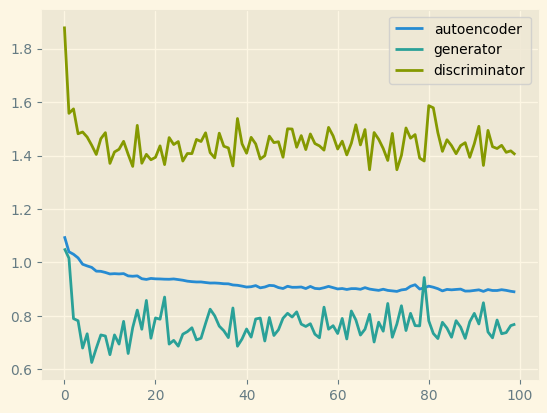

In [114]:
plt.plot(train_autoencoder_loss, label="autoencoder")
plt.plot(train_generator_loss, label="generator")
plt.plot(train_discriminator_loss, label="discriminator")
plt.legend()
plt.show()

In [115]:
test_cost_avg = [np.mean(np.abs(i)) for i in test_cost]
train_cost_avg = [np.mean(np.abs(i)) for i in train_cost]
validation_cost_avg = [np.mean(np.abs(i)) for i in validation_cost]

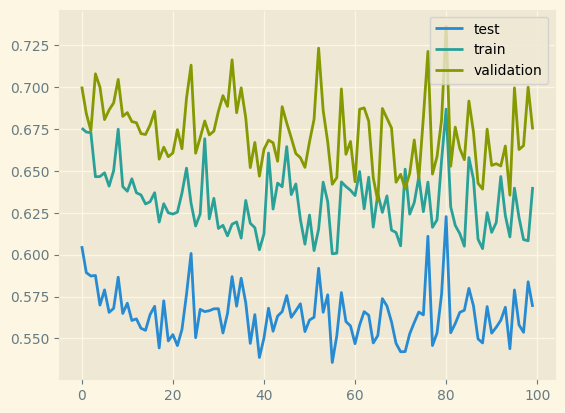

In [116]:
plt.plot(test_cost_avg, label="test")
plt.plot(train_cost_avg, label="train")
plt.plot(validation_cost_avg, label="validation")
plt.legend()
plt.show()

In [16]:
data_train = data_train.reshape(data_train.shape[0], data_train.shape[1], data_train.shape[2], 1)

input_shape = data_train.shape[1:]
latent_shape = 2

def make_encoder_model(z_size):
    inputs = tf.keras.layers.Input(shape=input_shape)
    if comment is True : print(f"encoder input: {inputs.shape}")
    x = layers.Conv1D(32, 5, padding="same", activation="relu", input_shape=input_shape)(inputs)
    x = layers.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv1D(128, 5, strides=2, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    z = layers.Dense(z_size, activation="linear")(x)
    if comment is True : print(f"endoder output: {z.shape}")

    model = tf.keras.Model(inputs=inputs, outputs=z)
    return model

def make_decoder_model(z_size):
    encoded = tf.keras.Input(shape=z_size)
    if comment is True : print(f"decoder input: {encoded.shape}")
    x = layers.Dense(12*23*128)(encoded)
    x = layers.Reshape((12, 23, 128))(x)
    x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    reconstruction = layers.Conv1D(1, 7, activation="sigmoid")(x)
    if comment is True : print(f"decoder output: {reconstruction.shape}")
    decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return decoder

def make_discriminator_model(z_size):
    encoded = tf.keras.Input(shape=(z_size, ))
    if comment is True : print(f"discriminator input: {encoded.shape}")
    x = layers.Dense(63, activation="relu", input_shape=(1, latent_shape))(encoded)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    prediction = tf.keras.layers.LeakyReLU(0.2)(x)
    if comment is True : print(f"discriminator output: {prediction.shape}")
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model